# Análise churn


<p style='text-align: justify;'><font size=3.>Para esse trabalho, foi escolhida uma base de dados fictícia de clientes de uma empresa de telefonia. Esses dados foram selecionados com o objetivo de aplicar técnicas de análise e exploração de dados de forma a descobrirmos os possíveis motivos que impactam na taxa de churn.</font></p>

<p style='text-align: justify;'><font size=2.5><b>Link da base</b>: https://drive.google.com/drive/folders/1-_RNEM2Ynqwe_zXAn1ZPbiFiBf6au4Ca?usp=sharing</font></p>

# Objetivo

<p style='text-align: justify;'><font size=3.>Churn, de uma forma geral, é uma métrica que indica o número de clientes que cancelam em determinado período de tempo. Desta forma, a análise de churn de clientes é uma estratégia essencial para que possamos entender e combater a perda de clientes e adotar medidas eficazes para retenção e satisfação dos consumidores. O objetivo é realizar uma análise de uma amostra dos dados para tentarmos identificar padrões associados ao cancelamento desses clientes. A ideia é que identificando esses grupos seja possível tomar decisões estratégicas e personalizar ofertas que atendam melhor às necessidades desses consumidores.</font></p>

![Descrição da Imagem](img/churn_objetivo.jpg)

## Bibliotecas

In [1]:
"""
    Bibliotecas básicas de DS
"""
import warnings
import numpy as np
import pandas as pd

"""
    Bibliotecas de visualização de dados
"""
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

"""
 Bibliotecas para análise do dataset
"""
import sidetable
from tabulate import tabulate

"""
    Geolocalização
"""
import geopandas as gpd
from geopy.geocoders import Nominatim


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

## Visão inicial do dataset

In [2]:
data = pd.read_excel('data/dados_analise_churn.xlsx')
print(f'Linhas: {data.shape[0]} | Coluna:  {data.shape[1]}')
data.head(1)

Linhas: 6087 | Coluna:  11


,IDCliente,Idade,Genero,Localização,Estado Civil,Dependentes,Valor Mensal do Contrato,Tipo de Serviço,MesesComoCliente,Número de Reclamações,Churn
0,1103,36,Feminino,Acre,Casado,Sim,44.1,Telefonia Móvel,58,1,Nao


### Informação dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6087 entries, 0 to 6086
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   IDCliente                 6087 non-null   int64  
 1   Idade                     6087 non-null   int64  
 2   Genero                    6087 non-null   object 
 3   Localização               6087 non-null   object 
 4   Estado Civil              6087 non-null   object 
 5   Dependentes               6087 non-null   object 
 6   Valor Mensal do Contrato  6087 non-null   float64
 7   Tipo de Serviço           6087 non-null   object 
 8   MesesComoCliente          6087 non-null   int64  
 9   Número de Reclamações     6087 non-null   int64  
 10  Churn                     6087 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 523.2+ KB


#### Valores nulos

In [4]:
data.stb.missing()

,missing,total,percent
IDCliente,0,6087,0.0
Idade,0,6087,0.0
Genero,0,6087,0.0
Localização,0,6087,0.0
Estado Civil,0,6087,0.0
Dependentes,0,6087,0.0
Valor Mensal do Contrato,0,6087,0.0
Tipo de Serviço,0,6087,0.0
MesesComoCliente,0,6087,0.0
Número de Reclamações,0,6087,0.0


#### Remoção das features

> Foi removida a coluna "IDCliente" que não será importante na análise.

In [5]:
data.drop(['IDCliente'], axis=1, inplace=True)
print('|'.join(data.columns))

Idade|Genero|Localização|Estado Civil|Dependentes|Valor Mensal do Contrato|Tipo de Serviço|MesesComoCliente|Número de Reclamações|Churn


## Perfil médio de todos os clientes

In [6]:
data.describe().round(2)

,Idade,Valor Mensal do Contrato,MesesComoCliente,Número de Reclamações
count,6087.00,6087.00,6087.00,6087.00
mean,45.59,65.72,32.49,4.98
std,14.69,30.88,24.51,3.20
min,20.00,18.25,1.00,0.00
25%,32.00,37.28,9.00,2.00
50%,45.00,70.85,29.00,5.00
75%,58.00,90.40,56.00,8.00
max,76.00,189.99,80.00,10.00


<p style='text-align: justify;'><font size=3.>A idade média dos clientes é de 45 anos com uma variação de 14.69 anos, sendo que temos um grupo com menos de 45 anos e o outro com mais de 45. Isso sugere que temos uma base composta por uma mistura de clientes mais jovens e de meia idade. Essa segmentação, pode nos ajudar a entender se os diferentes grupos etários possuem comportamento de churn diferentes. A partir disso, criar ações mais especializadas para a necessidade de cada grupo.</font></p>

<p style='text-align: justify;'><font size=3.>Os clientes pagam, em média, R$ 65,72/mensais pelos serviços. Uma análise interessante que podemos fazer é verificar se clientes que possuem contrato acima da média possuem maior probabilidade churn. Clientes com contratos mais caros possuem maior chance de cancelamento? Ofertas especializadas e descontos podem ser uma alternativa para retenção desses consumidores.</font></p>


<p style='text-align: justify;'><font size=3.>A média e a mediana de reclamações são relativamente baixas, indicando que, a maioria dos clientes não enfrentou problemas graves ou recorrentes. Seria interessante, a empresa investigar as razões por trás das reclamações mais frequentes e tomar medidas para abordar essas questões e melhorar a experiência do cliente.</font></p>

<p style='text-align: justify;'><font size=3.>Os contratos duram, em média, 32 meses. Podemos analisar essas informações para os clientes que cancelaram de forma a descobrir um padrão entre o grupo.</font></p>

In [7]:
data.describe(include='O')

,Genero,Localização,Estado Civil,Dependentes,Tipo de Serviço,Churn
count,6087,6087,6087,6087,6087,6087
unique,2,28,4,2,4,2
top,Masculino,São Paulo,Casado,Nao,Internet,Nao
freq,3099,249,2956,4243,2130,4496


<p style='text-align: justify;'><font size=3.>Na nossa base, temos que os clientes, em sua maioria, são casados, sem dependentes e do gênero masculino. Pode ser interessante apresentar soluções personalizadas com base no comportamento desses clientes.</font></p>

<p style='text-align: justify;'><font size=3.>São Paulo é a cidade mais frequente, podemos focar em melhorar os serviços nessa região, por exemplo, ou identificar oportunidades de expansão na área.</font></p>

<p style='text-align: justify;'><font size=3.>Nós também podemos propor ações que garantam a qualidade dos serviços mais contratados. Nesse caso, o serviço de maior contratação é a Internet.</font></p>

<p style='text-align: justify;'><font size=3.>A maioria da nossa base é de clientes ativos, o que faz sentido, uma vez que churn é evento menos comum nas empresas.</font></p>

### Churns vs. Não churns

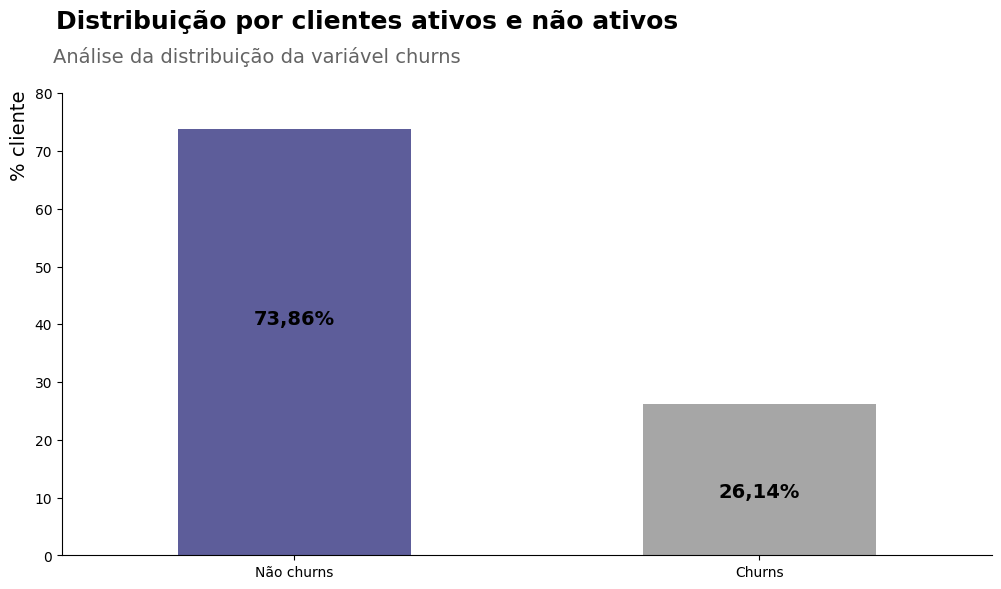

In [8]:
dist_freq = (data['Churn'].value_counts(normalize=True)*100).round(2).reset_index()
suptitle = 'Distribuição por clientes ativos e não ativos'
title = 'Análise da distribuição da variável churns'

colors=['#191970', '#808080']

dist_freq['proportion'].plot.bar(width=0.5, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.ylabel('% cliente', fontsize=14, horizontalalignment='left', y=0.812)
plt.ylim(0, 80)
plt.grid(False)
plt.text(0, 40, '73,86%', fontsize=14, weight='bold', horizontalalignment='center')
plt.text(1, 10, '26,14%', fontsize=14, weight='bold', horizontalalignment='center')
plt.gca().set_xticklabels(['Não churns', 'Churns'])
plt.savefig('img/churns.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'>Quase 27% da nossa base são de clientes que cancelaram seus serviços. Dependendo do contexto que a empresa opera, o churn pode considerado um evento menos comum. No nosso caso, faz sentido a empresa possuir mais clientes ativos do que cancelados, caso contrário ela estaria em sérios riscos. Como nosso objetivo é identificar padrões de comportamento dos ex-clientes, nossa análise vai focar nos churns.<font size=3.></font></p>

## Perfil dos clientes churn

> Visto que nosso interesse é entender melhor o comportamento dos churns, focaremos nossa análise nesse grupo.

In [9]:
churns= data.query('Churn=="Sim"')
print(f'Total de clientes que cancelaram: {len(churns)}')

Total de clientes que cancelaram: 1591


### Idade

> Obs.: densidade é a proporção de observações que caem em um determinado intervalo de valores no eixo x.

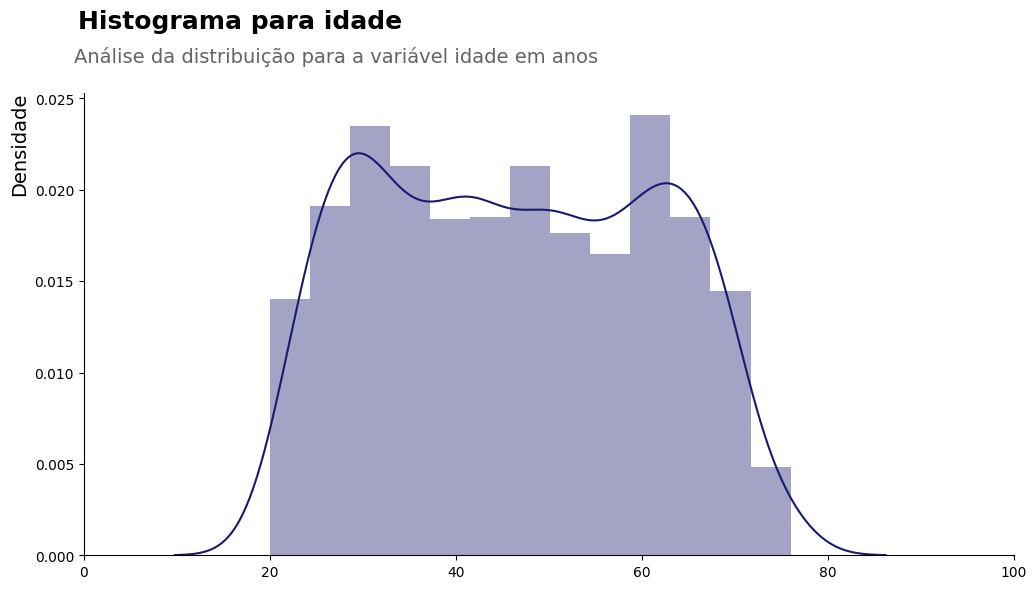

In [10]:
suptitle = 'Histograma para idade'
title = 'Análise da distribuição para a variável idade em anos'

ax = sns.distplot(churns['Idade'], kde=True, color='#191970')
ax.figure.set_size_inches(12, 6)
ax.set_ylabel('Densidade', fontsize=14, horizontalalignment='left', y=0.78)
ax.set_xlabel(None)
ax.spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlim(0, 100)
plt.grid(False)
plt.savefig('img/idade.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>Podemos ver que a idade dos clientes que cancelaram possui uma grande variação entre 32 e 61 anos, ou seja, isso sugere que clientes de diversas idades estão deixando a empresa. Junto com outas métricas podemos entender o comportamento desses consumidores e elaborar campanhas mais voltadas para esse grupo.</font></p>

### Sexo biológico

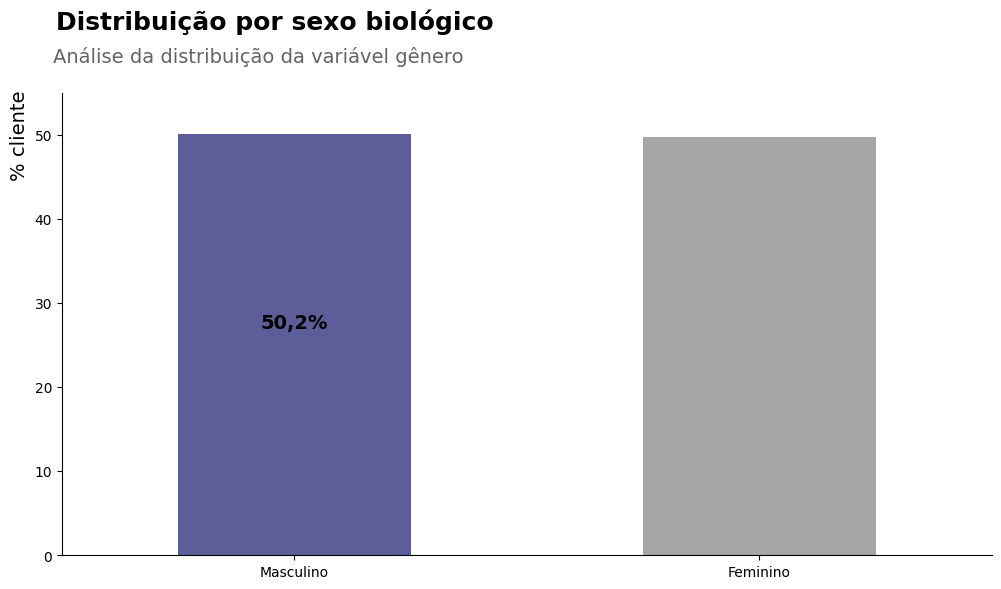

In [11]:
dist_freq = (churns['Genero'].value_counts(normalize=True)*100).round(2).reset_index()
suptitle = 'Distribuição por sexo biológico'
title = 'Análise da distribuição da variável gênero'

colors=['#191970', '#808080']

dist_freq['proportion'].plot.bar(width=0.5, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.ylabel('% cliente', fontsize=14, horizontalalignment='left', y=0.812)
plt.ylim(0, 55)
plt.grid(False)
plt.text(0, 27, '50,2%', fontsize=14, weight='bold', horizontalalignment='center')
plt.gca().set_xticklabels(['Masculino', 'Feminino'])
plt.savefig('img/genero.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>É possível identificar que a maioria dos clientes são do gênero masculino, representando aproximadamente 50.2% do total da base. Por outro lado, clientes do gênero feminino representam 49.8%. Essa é uma distribuição equilibrada, o que indica essa variável pode não ser um fator determinante para a saída dos clientes. Ainda sim, pode ser interessante adaptar as estratégias de marketing para atender cada segmento.</font></p>

### Estado civil

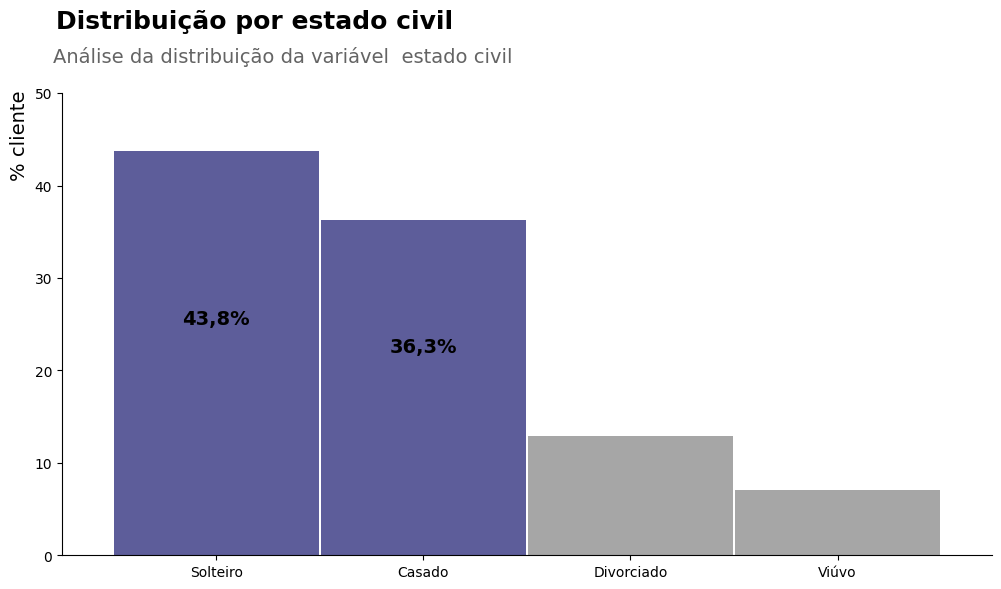

In [12]:
dist_freq = (churns['Estado Civil'].value_counts(normalize=True)*100).round(2).reset_index()
suptitle = 'Distribuição por estado civil'
title = 'Análise da distribuição da variável  estado civil'

colors=['#191970', '#191970', '#808080', '#808080']

dist_freq['proportion'].plot.bar(width=0.99, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.ylabel('% cliente', fontsize=14, horizontalalignment='left', y=0.812)
plt.ylim(0, 50)
plt.grid(False)
plt.text(0, 25, '43,8%', fontsize=14, weight='bold', horizontalalignment='center')
plt.text(1, 22, '36,3%', fontsize=14, weight='bold', horizontalalignment='center')
plt.gca().set_xticklabels(['Solteiro', 'Casado', 'Divorciado', 'Viúvo'])
plt.savefig('img/estado_civil.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>Em relação ao estado civil, temos 43,8% solteiros, 36,3% casados e 12,5% outros. Essa distribuição indica que essa variável pode ter um certo impacto na taxa de churn, uma vez que ela pode ser mais alta entre clientes casados e solteiros, em comparação com os demais. Pode ser interessante, nesse caso,  apresentar soluções personalizadas com base no comportamento desse maior grupo.</font></p>

### Localidade

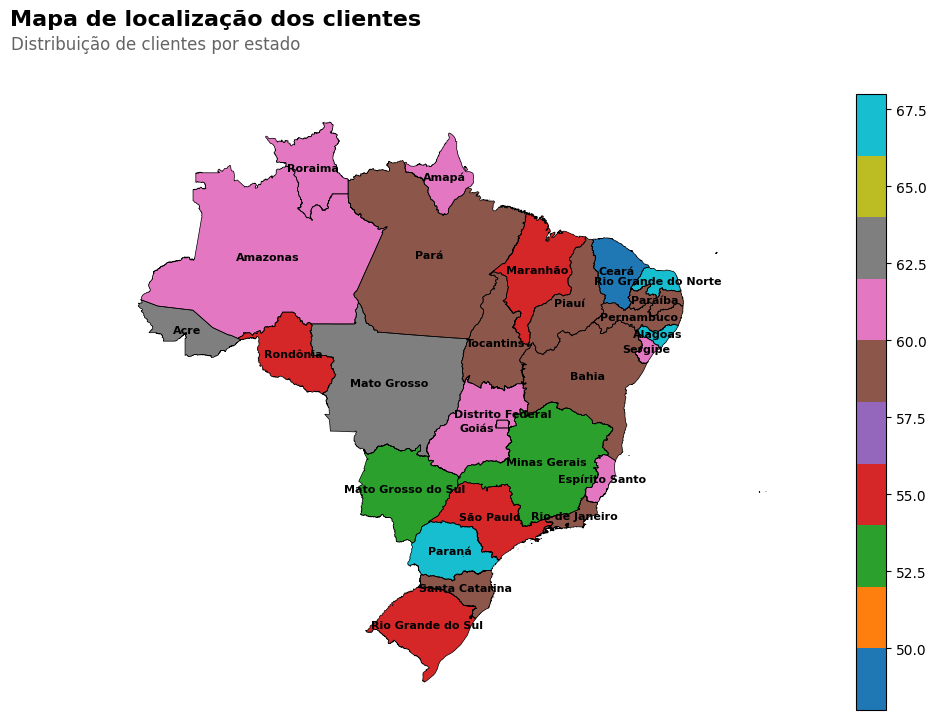

In [13]:
dist_freq = churns['Localização'].value_counts().reset_index()
dist_freq.columns = ['Localização', 'Clientes']

estados_mapa = gpd.read_file('BR_UF_2022/BR_UF_2022.shp')
estados_mapa = estados_mapa.merge(dist_freq, left_on='NM_UF', right_on='Localização', how='left')


fig, ax = plt.subplots(figsize=(15, 8))
estados_mapa.boundary.plot(ax=ax, linewidth=0.5, color='black')
estados_mapa.plot(column='Clientes', ax=ax, cmap='tab10', legend=True)

for x, y, label in zip(estados_mapa.geometry.centroid.x, estados_mapa.geometry.centroid.y, estados_mapa['NM_UF']):
    y_offset = 0.7
    if label == 'Distrito Federal':
        ax.text(x, y + y_offset, label, fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    else:
        ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black', fontweight='bold')

suptitle = 'Mapa de localização dos clientes'
title = 'Distribuição de clientes por estado'

plt.suptitle(suptitle, fontsize=16, y=0.986, horizontalalignment='left', x=0.22, color='black', weight='bold')
plt.title(title, fontsize=12, color='#646464', y=1.06, loc='left', x=-0.138)

ax.set_axis_off()
plt.savefig('img/mapa_clientes.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>O mapa representa a quantidade de clientes que cancelaram os serviços em cada estado com base nas cores. A barra lateral mosta a média da soma dos clientes para cada grupo de cor. Sendo assim, os estados com maior incidência de churn são Paraná, Rio Grande do Norte e Alagoas que concentra 13% de cancelamento. O Ceará está sozinho, com a menor taxa de churns (3%).</font></p>

<p style='text-align: justify;'><font size=3.>Essa é uma variável importante para identificarmos a região com maior ocorrência de perda de clientes e focarmos em melhorar os serviços nessa área, por exemplo, ou identificar oportunidades de expansão. Neste caso, o Nordeste possui 2 dos estados que mais cancelaram, portanto vale a pena estudar o comportamento desse grupo para propor campanhas e ofertas especiais.</font></p>

### Tipo de Serviço

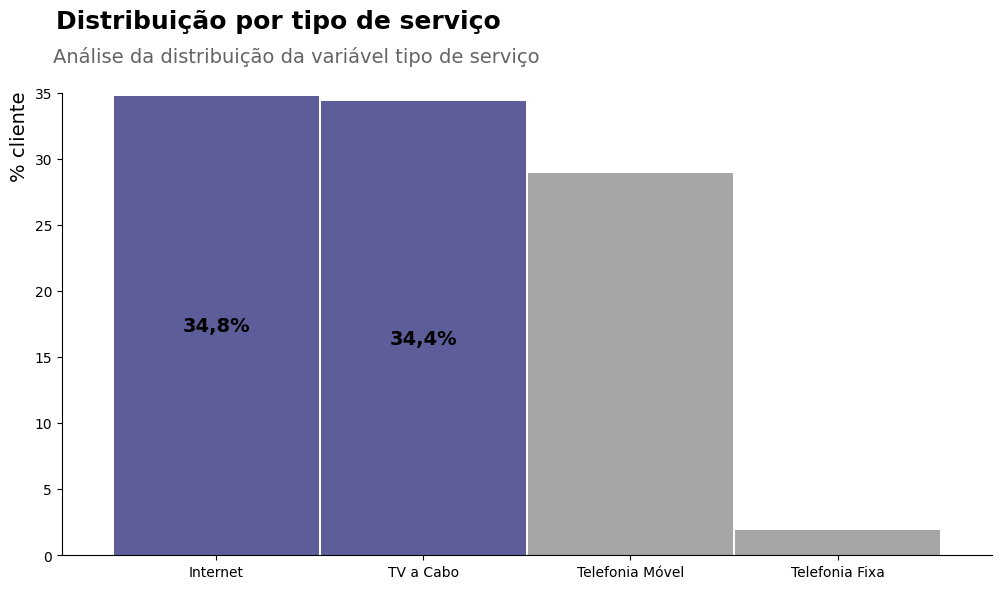

In [14]:
dist_freq = (churns['Tipo de Serviço'].value_counts(normalize=True)*100).round(2).reset_index()

suptitle = 'Distribuição por tipo de serviço'
title = 'Análise da distribuição da variável tipo de serviço'

colors=['#191970', '#191970', '#808080', '#808080']

dist_freq['proportion'].plot.bar(width=0.99, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.ylabel('% cliente', fontsize=14, horizontalalignment='left', y=0.81)
plt.ylim(0, 35)
plt.grid(False)
plt.text(0, 17., '34,8%', fontsize=14, weight='bold', horizontalalignment='center')
plt.text(1, 16., '34,4%', fontsize=14, weight='bold', horizontalalignment='center')
plt.gca().set_xticklabels(['Internet', 'TV a Cabo', 'Telefonia Móvel', 'Telefonia Fixa'])
plt.savefig('img/tipo_servico.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>A maioria dos contratos cancelados são dos serviços de internet e TV a cabo. Podemos avaliar como está a prestação desses serviços e buscar formas de melhorar a experiência do usuário e satisfação dos clientes.</font></p>

### Valor Mensal do Contrato

> Obs.: densidade é a proporção de observações que caem em um determinado intervalo de valores no eixo x.

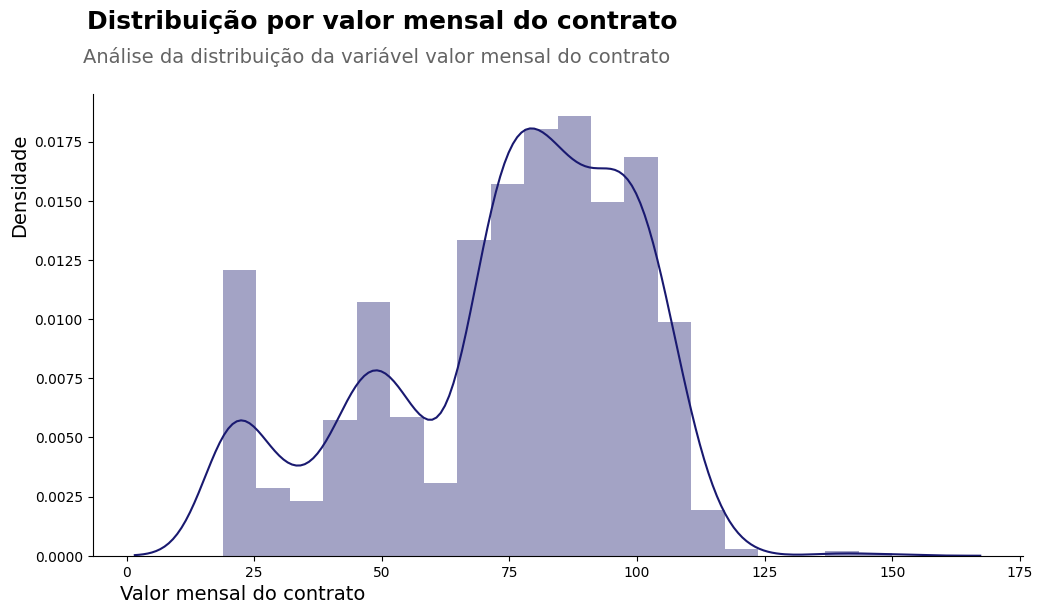

In [15]:
suptitle = 'Distribuição por valor mensal do contrato'
title = 'Análise da distribuição da variável valor mensal do contrato'

ax = sns.distplot(churns['Valor Mensal do Contrato'], kde=True, color='#191970')
ax.figure.set_size_inches(12, 6)
ax.set_ylabel('Densidade', fontsize=14, horizontalalignment='left', y=0.69)
ax.set_xlabel('Valor mensal do contrato', fontsize=14, horizontalalignment='left', x=0.03)
ax.spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.grid(False)
plt.savefig('img/valor_mensal.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>A média dos contratos são de R\$ 74,31 reais/mensais com uma variação de R\$ 25,12 reais para mais ou para menos. Isso sugere que existe uma variabilidade significativa nos valores mensais dos contratos. Alguns clientes pagam valores próximos à média, enquanto outros pagam valores consideravelmente mais baixos ou mais altos.</font></p>

<p style='text-align: justify;'><font size=3.>Outro ponto a ser observado é que a maior parte dos clientes que cancelaram possuiam contratos mais altos, acima da média. Isso pode ser útil para entender o perfil de gastos dos clientes que deixaram a empresa em relação aos que permaneceram, bem como para avaliar se os preços dos planos de telefonia estão alinhados com as expectativas dos consumidores.</font></p> 

### Meses como cliente

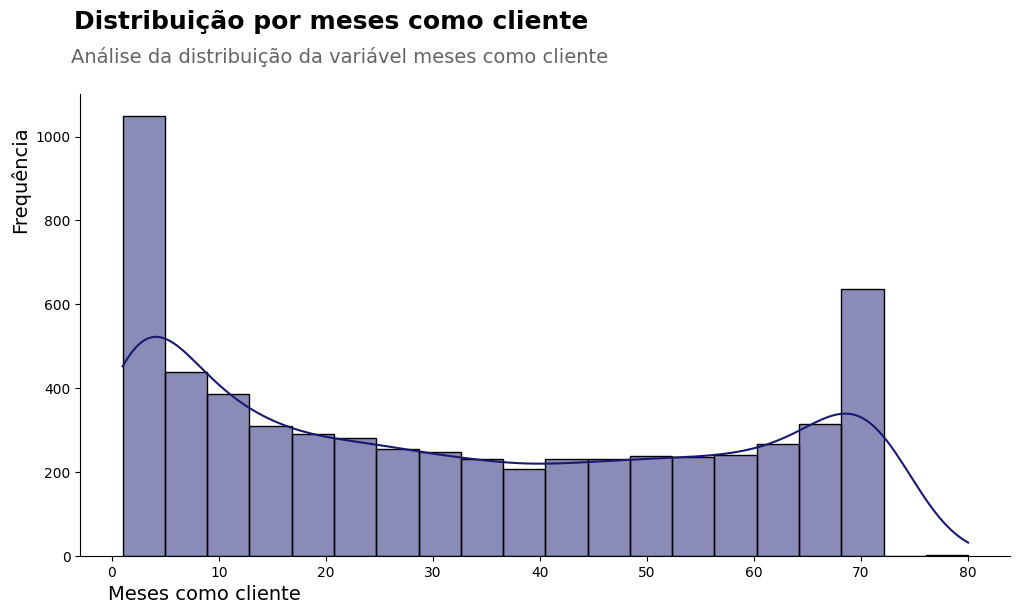

In [16]:
suptitle = 'Distribuição por meses como cliente'
title = 'Análise da distribuição da variável meses como cliente'

plt.figure(figsize=(12, 6))
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
sns.histplot(data['MesesComoCliente'], bins=20, kde=True, color='#191970').spines[['top', 'right']].set_visible(False)
plt.xlabel('Meses como cliente', fontsize=14, horizontalalignment='left', x=0.03)
plt.ylabel('Frequência', fontsize=14, horizontalalignment='left', y=0.70)
plt.grid(False)
plt.savefig('img/meses_como_cliente.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>A média de meses como cliente é de aproximadamente 18.22 meses. Isso indica que, em média, os consumidores permanecem na empresa por cerca de 1 ano e meio antes de cancelarem. O desvio padrão de 19.65 meses indica uma variação considerável nos tempos de permanência dos clientes, sendo que alguns podem deixar a empresa após um curto período, enquanto outros podem permanecer por um período muito mais longo.</font></p>

<p style='text-align: justify;'><font size=3.>Temos dois pontos interessantes nesse gráfico: primeiro, há uma concentração de churns nos primeiros meses (1 a 10 meses) que sugere que muitos clientes decidiram deixar a empresa após um curto período de experimentação ou insatisfação inicial. Por outro lado, temos a presença de churns em prazos mais longos (acima de 1 ano), indicando que há clientes que permaneceram na empresa por um tempo significativo antes de decidirem cancelar os serviços.</font></p>

<p style='text-align: justify;'><font size=3.>Isso pode ser resultado de diferentes fatores, como problemas de qualidade, mudança nas necessidades do cliente ao longo do tempo, uma tendência sazional ou ocorrência de eventos específicos, como por exemplo promoções de fim de ano. O caminho seria entender os motivos e buscar ofertas especializadas e promoções para manter esses clientes por mais tempo.</font></p>

### Número de Reclamações

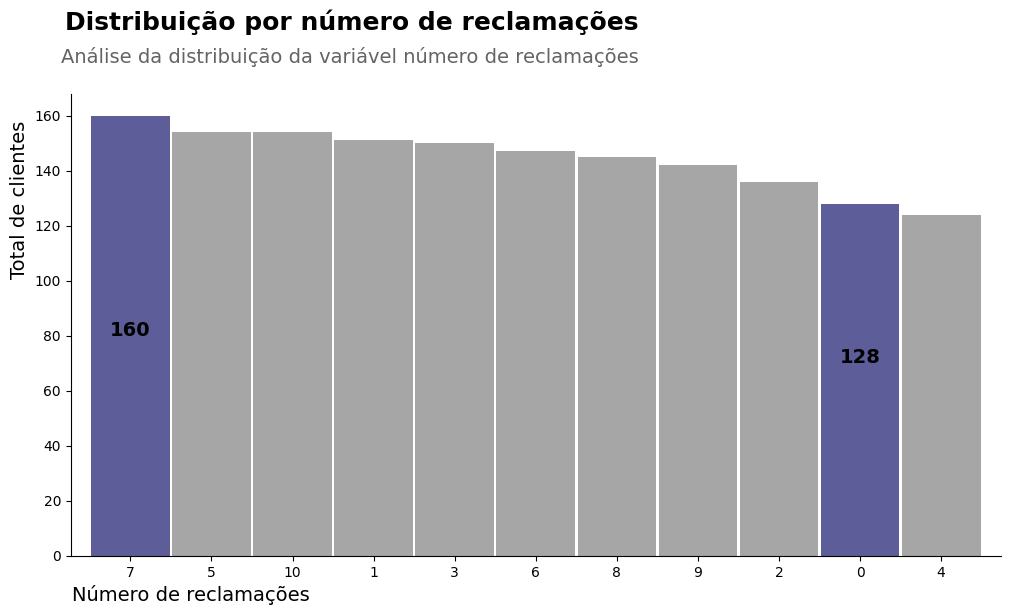

In [17]:
suptitle = 'Distribuição por número de reclamações'
title = 'Análise da distribuição da variável número de reclamações'

colors= ['#191970'] + ['#808080'] * 8 + ['#191970'] + ['#808080']

churns['Número de Reclamações'].value_counts().plot.bar(width=0.97, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlabel('Número de reclamações', fontsize=14, horizontalalignment='left', x=0.001)
plt.ylabel('Total de clientes', fontsize=14, horizontalalignment='left', y=0.60)
plt.grid(False)
plt.text(0, 80., '160', fontsize=14, weight='bold', horizontalalignment='center')
plt.text(9, 70., '128', fontsize=14, weight='bold', horizontalalignment='center')
plt.savefig('img/recalamacoes.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>Dos 1591 clientes que reincindiram o contrato, aproximadamente 10% registrou 7 reclamações, 8% não registrou nenhuma reclamação e os demais tiveram, pelo menos, uma reclamação registrada (82%). Ou seja, 92% desses clientes tiveram problemas com os serviços em determinado momento e compreender o motivo disso, pode ajudar a elaborar estratégias de retenção dos consumidores.</font></p>

## Análise de correlação

> Correlação é uma medida que indica se e até que ponto as mudanças em uma variável estão associadas às mudanças em outra variável.

In [18]:
churns[['Idade', 'Valor Mensal do Contrato', 'MesesComoCliente', 'Número de Reclamações']].corr()

,Idade,Valor Mensal do Contrato,MesesComoCliente,Número de Reclamações
Idade,1.000000,0.004005,0.027275,-0.020935
Valor Mensal do Contrato,0.004005,1.000000,0.396113,-0.039676
MesesComoCliente,0.027275,0.396113,1.000000,-0.014328
Número de Reclamações,-0.020935,-0.039676,-0.014328,1.000000


<p style='text-align: justify;'><font size=3.>De uma maneira geral, não parece haver relações  fortes entre as variáveis analisadas. A maior correlação foi entre o valor mensal do contrato e meses como cliente de 0,39, o que indica uma correlação moderada positiva que sugere que clientes com contratos de maior valor tendem a permanecer mais tempo na empresa. Isso poderia indicar que oferecer opções de contratos mais vantajosos ou que agregam mais valor aos clientes pode ajudar a reduzir o churn.</font></p>

### Valor Mensal do Contrato vs. Meses como cliente

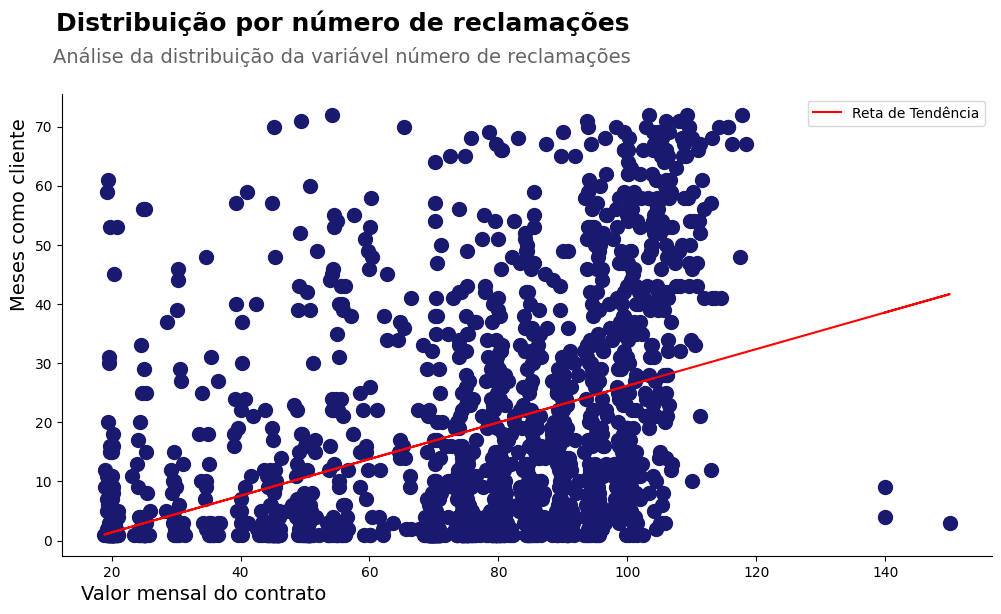

In [19]:
x = churns['Valor Mensal do Contrato']
y = churns['MesesComoCliente']

coef = np.polyfit(x, y, 1)
polynomial = np.poly1d(coef)

plt.figure(figsize=(12, 6))
plt.scatter(churns['Valor Mensal do Contrato'], churns['MesesComoCliente'], color='#191970', s=100)
plt.plot(x, polynomial(x), color='red', label='Reta de Tendência')  # Adicionar a reta de tendência
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.ylabel('Meses como cliente', fontsize=14, horizontalalignment='left', y=0.53)
plt.xlabel('Valor mensal do contrato', fontsize=14, horizontalalignment='left', x=0.02)
plt.grid(False)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()
plt.savefig('img/correlacao.png', dpi=300, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'><font size=3.>Quanto mais próximos os pontos estiverem da linha de tendência, mais forte é a correlação. E no nosso caso, podemos ver que existe uma dispersão desses pontos, embora eles estejam no mesmo sentido positivo, portanto vemos uma correlação moderada. Além disso, temos alguns pontos que estão mais distantes e podem indicar clientes com comportamentos atípicos, indicando, por exemplo, comportamentos únicos em relação ao churn ou problemas isolados que levaram ao cancelamento. A análise desses clientes pode ser importante para a identificação de oportunidades de retenção.</font></p>